In [5]:
import numpy as np
import xarray as xr
import pandas as pd

from io_tools import radolan
import matplotlib.pyplot as plt
%matplotlib inline

from plotting_tools.colormaps import radar_cmap as rc
from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmed=240,vmax=300)

from standard_config import *

import MSGtools as mst
import datetime as dt
import load_satellite_data as lsd
import fixed_colourbar as fc

from analysis_tools import grid_and_interpolation as gi

import geooperations as go
import sys

from scipy import ndimage as ndi

import haci as hci
from haci import filters as hcf

In [6]:
def cutout_box(data, row, col, box_size):
    cutout = gi.cutout_field4box(data,(row,col),box_size)
    
    return cutout

def get_index_kdtree(points, lat, lon):
    """
    Determine index of given points in the given coordinate arrays.
    
    Inputs:
        points: array-like, array([[lats],[lons]]), float
            points for which the indices are to be determined
        lat: array-like, float
            array of latitude coordinates 
        lon: array-like, float
            array of longitude coordinates
        
    Returns:
        indices: list with index sets of closest coordinate points to the given points    
    """
    
    from scipy.spatial import cKDTree
    import numpy as np
    
    # combine coordinate arrays into one stack
    combined_coordinate_arrays = np.dstack([lat.ravel(),lon.ravel()])[0]
    
    # transform points into a list
    points_list = list(points.transpose())
    
    # create cKDTree in which to look for the coordinates 
    tree = cKDTree(combined_coordinate_arrays)
    
    # query cKDTree
    dist, indices = tree.query(points_list)
    
    # re-transform coordinates to match starting coordinate array shapes
    results = []
    
    for idx in indices:
        results.append(np.unravel_index(idx,lon.shape))
        
    return results

In [7]:
haci_path = "{}/HACI_bbox_data/".format(local_data_path)

In [8]:
seviri_path = "{}/SEVIRI/".format(local_data_path)

In [9]:
# haci_cases = pd.read_csv("{}/HACI_bbox_filtered.csv".format(haci_path))
haci_cases = pd.read_csv("{}/haci-2013-06-18-bbox.dat".format(haci_path),sep="\s+")

In [10]:
haci_cases, dt_filter = hcf.duration_filter(haci_cases,6)

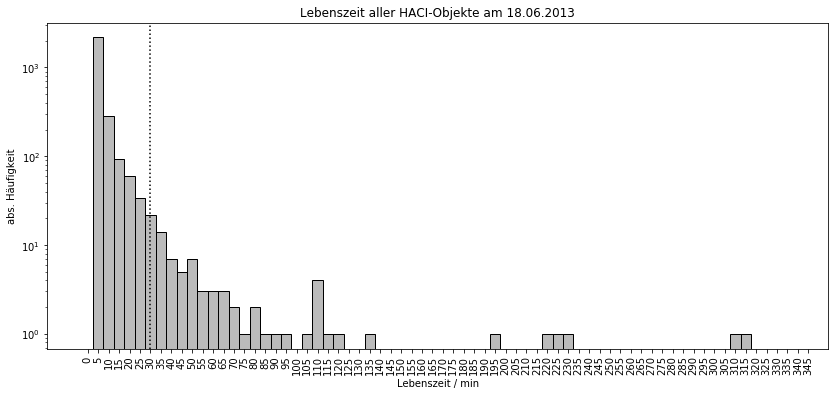

In [11]:
fig,ax = plt.subplots(1,1,figsize=(14,6))
bins = np.arange(0,np.max(haci_cases.dt.values*5),5) - 2.5
H, xedges, yedges= ax.hist(haci_cases.dt.values*5,
                           bins=bins,
                           edgecolor='k',
                           color='#00000044')
ax.set_xticks(np.arange(0,haci_cases.dt.values.max()*5+5,5))
ax.set_xlabel("Lebenszeit / min")
ax.set_ylabel(u"abs. Häufigkeit")
ax.set_title("Lebenszeit aller HACI-Objekte am 18.06.2013")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.yscale("log")
#ax.set_xlim([-2.5, 202.5])
plt.axvline(30,color='k',linestyle=':')

Das sieht viel besser aus, als bei der vorherigen Variante! Jetzt werden nicht mehr alle Objekte mit einer Lebenszeit von mehr als 30&thinsp;min in die Klasse von 30&thinsp;min aggregiert.

Dann suchen wir uns doch mal einen Fall aus.

In [12]:
haci_cases, ag_filter = hcf.area_growth_filter(haci_cases)

In [64]:
haci_cases, ar_filter = hcf.area_ratio_filter(haci_cases,20,35,0.2)

Filtering HACI objects for area ratios...: 100%|██████████| 2740/2740 [00:02<00:00, 1053.82it/s]


In [65]:
np.unique(haci_cases.area_ratio > 0.2,return_counts=True)

(array([False,  True]), array([  50, 2690]))

In [66]:
np.unique(ar_filter,return_counts=True)

(array([False,  True]), array([  50, 2690]))

In [67]:
haci_cases_filtered = haci_cases[(ar_filter) & (dt_filter) & (ag_filter)]

In [68]:
haci_cases_filtered

,date,time,id,flags,t0,t1,l00,l01,c00,c01,l0,l1,c0,c1,dt,area0,area_max,darea,area_ratio
160,2013-06-18,01:00,336,0,12,35,143,145,404,406,106,187,387,436,23,4,3969,3965,0.502538
191,2013-06-18,01:05,381,0,13,32,623,625,821,826,617,640,820,899,19,10,1817,1807,0.344262
1383,2013-06-18,11:35,2336,0,139,156,850,864,601,607,850,869,593,613,17,84,380,296,0.352941
1571,2013-06-18,13:50,2687,0,166,188,386,392,615,619,381,404,607,638,22,24,713,689,0.232558
1669,2013-06-18,14:35,2831,0,175,202,263,269,652,659,262,294,639,668,27,42,928,886,0.219298
1707,2013-06-18,15:00,2913,0,180,195,364,365,723,724,356,373,723,746,15,1,391,390,0.686957
1780,2013-06-18,15:45,3029,0,189,200,363,370,710,716,356,371,709,726,11,42,255,213,0.285714
1842,2013-06-18,16:40,3132,0,200,209,481,483,412,417,481,498,412,434,9,10,374,364,0.800000
1895,2013-06-18,17:20,3207,0,208,216,473,477,402,407,470,484,400,417,8,20,238,218,0.238095
1981,2013-06-18,18:00,3328,0,216,223,434,440,860,865,424,440,860,875,7,30,240,210,0.272727


In [69]:
case = haci_cases_filtered.loc[1571]

In [70]:
t = dt.datetime(int(case.date.split("-")[0]),
                int(case.date.split("-")[1]),
                int(case.date.split("-")[2]),
                int(case.time.split(":")[0]),
                int(case.time.split(":")[1]))

In [72]:
# s = xr.open_dataset("{}/MSG_NWCSAF_{}Z-RSS-EU.nc".format(seviri_path,t.strftime("%Y%m%dT%H%M")))
s = lsd.load_satellite_data(t,"IR_108")

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


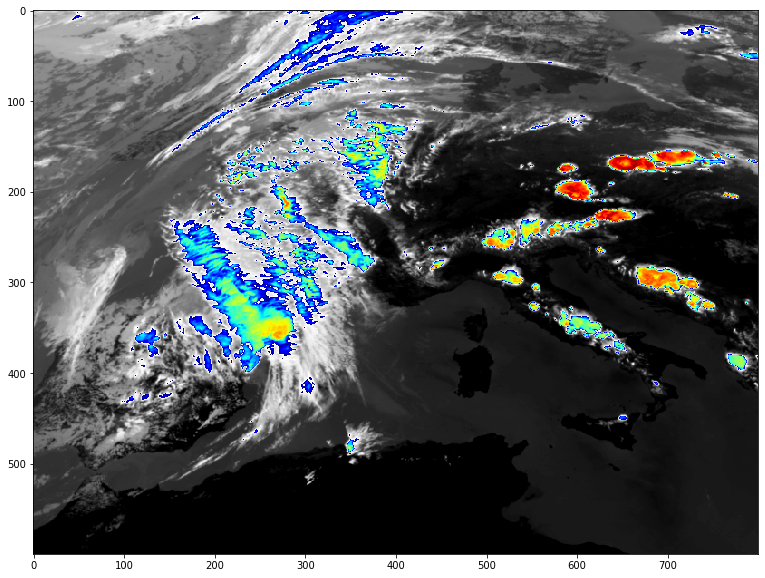

In [73]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
#ax.imshow(s.IR_108.data[0],vmin=210,vmax=300,cmap=emap)
ax.imshow(s,vmin=210,vmax=300,cmap=emap)

In [75]:
r = radolan.Radolan()

In [76]:
r.read(t)

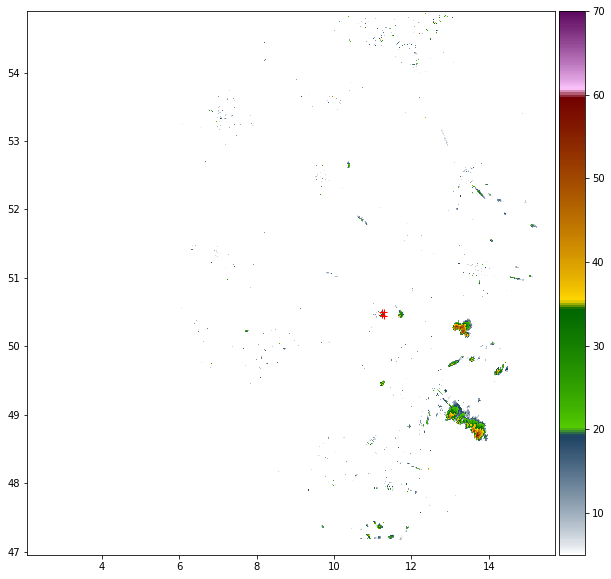

In [79]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
p0 = ax.pcolormesh(r.lon,r.lat,r.data,vmin=5,vmax=70,cmap=rc())

for i, case in haci_cases_filtered[haci_cases_filtered.time=="13:50"].iterrows():
    ax.plot(r.lon[case.l00,case.c00],r.lat[case.l00,case.c00],'r+')
    ax.plot(r.lon[case.l00,case.c01],r.lat[case.l00,case.c01],'r+')
    ax.plot(r.lon[case.l01,case.c00],r.lat[case.l01,case.c00],'r+')
    ax.plot(r.lon[case.l01,case.c01],r.lat[case.l01,case.c01],'r+')
fc.colourbar(p0)

In [89]:
tci_cutouts = []

In [135]:
# def get_data_from_nc(time,field):
#     s = xr.open_dataset("{}/MSG_NWCSAF_{}Z-RSS-EU.nc".format(seviri_path,time.strftime("%Y%m%dT%H%M")))

#     if isinstance(field,list):
#         sdata = {f:[] for f in field}
        
#         for f in field:
#             if f in ['lon','lat']:
#                 sdata[f] = s[f].data.copy()
#             else:
#                 sdata[f] = s[f].data[0].copy()
#         return sdata
#     else:
#         print(field)
#         if field in ['lon','lat']:
#             return s[field].data.copy()
#         else:
#             return s[field].data[0].copy()
#     s.close()

In [136]:
# def open_data_from_nc(time,field):
#     t0 = time - dt.timedelta(minutes=30)
#     t1 = time
#     t2 = time + dt.timedelta(minutes=30)
    
#     times = [t0,t1,t2]
#     data = []
    
#     for t in times:
#         data.append(get_data_from_nc(t,field))
        
#     return data

In [81]:
fields = ['IR_108','CTTH','lon','lat']

In [82]:
slon,slat = mst.get_msg_lon_lat('eu')

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [102]:
#for i, case in hc_dt6.iterrows():
for i, case in haci_cases_filtered.iterrows():
    #try:
        t = dt.datetime(int(case.date.split("-")[0]),
                        int(case.date.split("-")[1]),
                        int(case.date.split("-")[2]),
                        int(case.time.split(":")[0]),
                        int(case.time.split(":")[1]))
        
        #data = open_data_from_nc(t,fields)
        ir108 = lsd.load_satellite_data(t,'IR_108')
        cth = mst.get_nwcsaf_prod("CTTH_HEIGHT",t,calibrate=True)
        
        cutouts = []

        for d in data:
            #ir108 = d['IR_108']
            #cth = d['CTTH']

#             ir108_corr =  go.parallax_correct_msg(d['IR_108'],
#                                                   d['lon'],
#                                                   d['lat'],
#                                                   d['CTTH'],'std','eu','rss',1)
            ir108_corr =  go.parallax_correct_msg(ir108,
                                                  slon,
                                                  slat,
                                                  cth,'std','eu','rss',1)
            cutout_ir108 = cutout_box(ir108_corr,case.msg_eu_l00,case.msg_eu_c00,51)
            cutouts.append(cutout_ir108)

        cutout = np.hstack((cutouts[0],cutouts[1],cutouts[2]))
        tci_cutouts.append(cutout)
    #except:
    #    continue

Region suggests use of hdf file


NameError: name 'data' is not defined

In [101]:
mst.get_nwcsaf_prod?

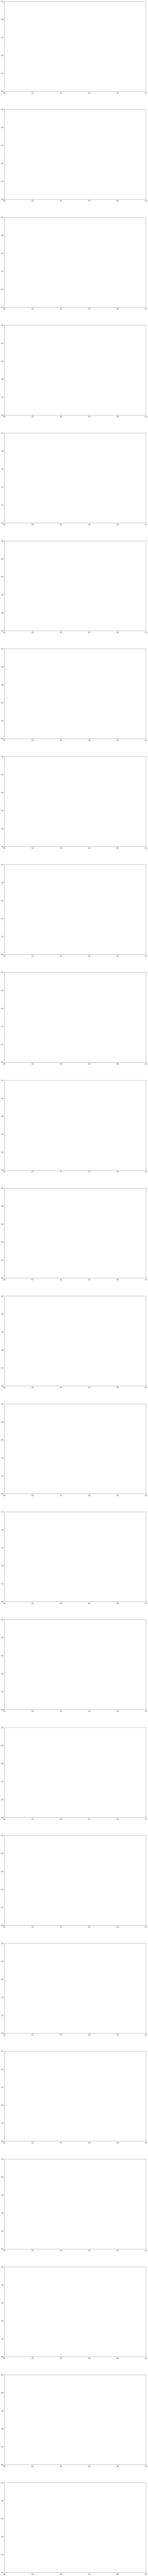

In [86]:
fig,ax = plt.subplots(24,1,figsize=(18,24*14))
axs = ax.ravel()

for i, c in enumerate(tci_cutouts):
#     t = dt.datetime(int(haci_cases[haci_cases.date=="2010-05-24"].iloc[i].date.split("-")[0]),
#                     int(haci_cases[haci_cases.date=="2010-05-24"].iloc[i].date.split("-")[1]),
#                     int(haci_cases[haci_cases.date=="2010-05-24"].iloc[i].date.split("-")[2]),
#                     int(haci_cases[haci_cases.date=="2010-05-24"].iloc[i].time.split(":")[0]),
#                     int(haci_cases[haci_cases.date=="2010-05-24"].iloc[i].time.split(":")[1]))
#     axs[i].imshow(c,vmin=210,vmax=300,cmap=emap)
#     axs[i].set_title(u"Fall {}, {} {} ± 30 min".format(haci_cases[haci_cases.date=="2010-05-24"].iloc[i].id,
#                                                        haci_cases[haci_cases.date=="2010-05-24"].iloc[i].date,
#                                                        haci_cases[haci_cases.date=="2010-05-24"].iloc[i].time))

    t = dt.datetime(int(haci_cases_filtered.iloc[i].date.split("-")[0]),
                    int(haci_cases_filtered.iloc[i].date.split("-")[1]),
                    int(haci_cases_filtered.iloc[i].date.split("-")[2]),
                    int(haci_cases_filtered.iloc[i].time.split(":")[0]),
                    int(haci_cases_filtered.iloc[i].time.split(":")[1]))
    axs[i].imshow(c,vmin=210,vmax=300,cmap=emap)
    axs[i].set_title(u"Fall {}, {} {} ± 30 min".format(haci_cases_filtered.iloc[i].id,
                                                       haci_cases_filtered.iloc[i].date,
                                                       haci_cases_filtered.iloc[i].time))

In [92]:
tci_cutouts

[]

## Herauslösen der Objekte

Das machen wir mit dem Ansatz von Hartwig.

In [104]:
def local_threshold(T, Tmax=273.15, thresh_min=240, Tmin=220, spread=5, factor = 10):
    #T_thresh = np.max((T + spread, T + spread + factor*(T - Tmax)/ (Tmin - Tmax),thresh_min))
    T_thresh = np.max((T + spread, T + spread + factor*(T - Tmax)/ (Tmin - Tmax)))
    return T_thresh

def get_labeled_local_minima(data,depth=10):
    from skimage.morphology import h_minima
    from scipy import ndimage as ndi
    
    minima = h_minima(data,depth)
        
    return (ndi.label(minima)[0])

def get_mask_threshold(field,max_threshold,spread):
    """
    Determine threshold from given field. If the field minimum is lower than the given threshold,
    the threshold to determine the cloud edge is determined using the given spread.
    
    Inputs:
        * field: array-like, 2-dimensional
            numpy array with the field data
        * max_threshold: int or float
            threshold of the cloud edge
        * spread: int or float
            spread to determine cloud edge, if the minimum is lower than the threshold
            
    Returns:
        * threshold: int or float
            derived threshold
    """
    # get minimum of the field
    field_min = np.min(field)
    
    if field_min >= max_threshold:
        return np.nan
    else:
        # determine spread
        spread = np.min((max_threshold-field_min,spread))

        # return threshold
        return np.min((field_min+spread,max_threshold))

In [12]:
case = haci_cases[(haci_cases.date=="2010-05-24") & (haci_cases.id==1697)]

In [13]:
case.date.iloc[0]

'2010-05-24'

In [14]:
t = dt.datetime(int(case.date.iloc[0].split("-")[0]),
                int(case.date.iloc[0].split("-")[1]),
                int(case.date.iloc[0].split("-")[2]),
                int(case.time.iloc[0].split(":")[0]),
                int(case.time.iloc[0].split(":")[1]))

tlist = pd.date_range(start=(t-dt.timedelta(minutes=30)).strftime("%Y%m%dT%H%M"),
                      end=(t+dt.timedelta(minutes=30)).strftime("%Y%m%dT%H%M"),
                      freq="5min")

In [24]:
data = {f:[] for f in fields + ['rlon', 'rlat', 'Z']}

In [23]:
r = radolan.Radolan()

In [25]:
for t in tlist:
    d = get_data_from_nc(t.to_pydatetime(),fields)
    
    for f in data.keys():
        if f in ['lon','lat']:
            cutout = cutout_box(d[f],case.msg_eu_l00.iloc[0],case.msg_eu_c00.iloc[0],51)
            data[f].append(cutout) 
        elif f in ['rlon', 'rlat','Z']:
            if f == 'rlon':
                cutout = cutout_box(r.lon,case.l00.iloc[0],case.c00.iloc[0],51)
                data[f].append(cutout)
            elif f == 'rlat':
                cutout = cutout_box(r.lat,case.l00.iloc[0],case.c00.iloc[0],51)
                data[f].append(cutout)
            else:
                r.read(t.to_pydatetime())
                Z = r.data
            
                cutout = cutout_box(Z,case.l00.iloc[0],case.c00.iloc[0],51)
                data[f].append(cutout)
        else:
            corr = go.parallax_correct_msg(d[f],
                                           d['lon'],
                                           d['lat'],
                                           d['CTTH'],'std','eu','rss',3)

            cutout = cutout_box(corr,case.msg_eu_l00.iloc[0],case.msg_eu_c00.iloc[0],51)
            data[f].append(cutout)

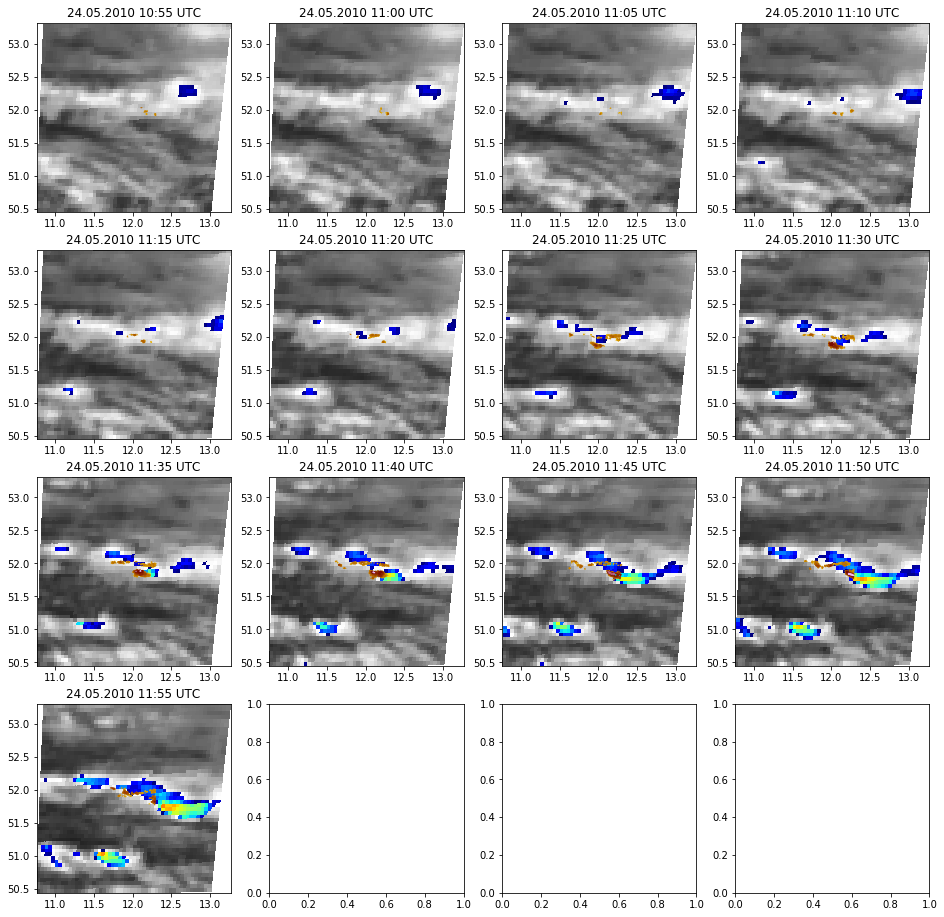

In [26]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs= ax.ravel()

for i, ir in enumerate(data['IR_108']):
    axs[i].pcolormesh(data['lon'][i],
                      data['lat'][i],
                      ir, vmin=210,vmax=300,cmap=emap)
    axs[i].contour(data['rlon'][i],
                   data['rlat'][i],
                   np.ma.masked_less(data['Z'][i],35), vmin=5, vmax=65, cmap=rc())
    axs[i].set_title(u"{}".format(tlist[i].strftime("%d.%m.%Y %H:%M UTC")))

In [103]:
locmin = np.zeros_like(np.array(data['IR_108']),dtype="uint8")

In [105]:
for i,sd in enumerate(data['IR_108']):
    lm = get_labeled_local_minima(sd,5)
    
    locmin[i,:,:] = lm

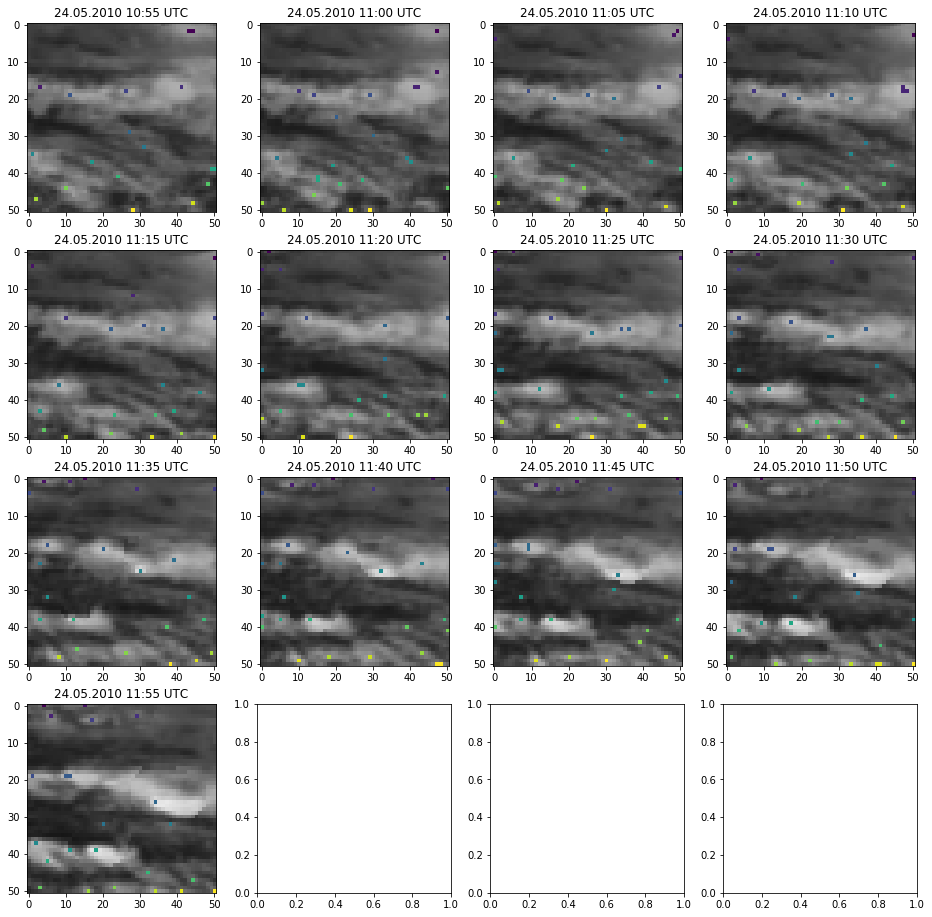

In [106]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs= ax.ravel()

for i, lm in enumerate(locmin):
    axs[i].imshow(data['IR_108'][i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(lm,1))    
    axs[i].set_title(u"{}".format(tlist[i].strftime("%d.%m.%Y %H:%M UTC")))

In [107]:
segmented = np.zeros_like(data['IR_108'],dtype="uint8")
object_minimum = np.zeros_like(data['IR_108'])
object_threshold = np.zeros_like(data['IR_108'])

In [108]:
for i,lm in enumerate(locmin):
    for l in np.unique(lm)[1:]:
        minimum_value = np.unique(data['IR_108'][i][np.where(lm==l)])
        threshold_value = local_threshold(minimum_value,spread=5,factor=5)
        #threshold_value = get_mask_threshold(minimum_value,273.15,7)
        
        if np.isnan(threshold_value):
            continue
        else:
            mask = np.ma.masked_greater(data['IR_108'][i],threshold_value)
            mask_labeled = ndi.label(~mask.mask*1)[0]
            lokmin_location = np.where(lm == l)
            wanted_obj_id = np.unique(mask_labeled[lokmin_location])[0]
            wanted_obj_location = np.where(mask_labeled==wanted_obj_id)

            segmented[i][wanted_obj_location] = l
            object_minimum[i][wanted_obj_location] = np.min(data['IR_108'][i][wanted_obj_location])
            object_threshold[i][wanted_obj_location] = threshold_value

Text(0.5, 0.98, 'Objekte')

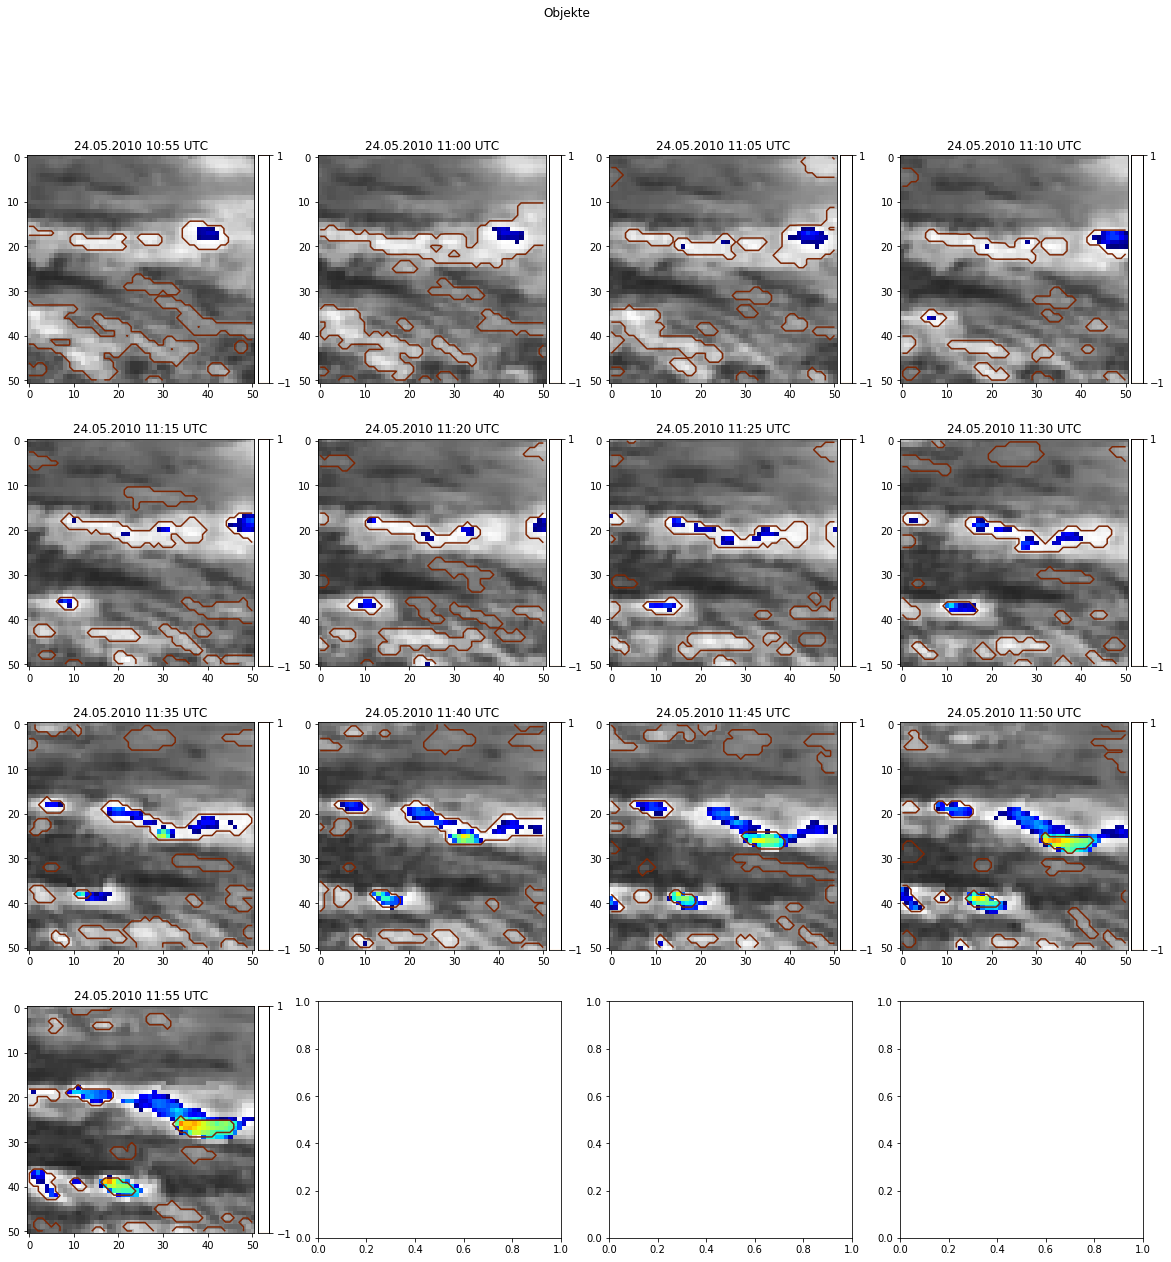

In [110]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
axs= ax.ravel()

for i, o in enumerate(segmented):
    axs[i].imshow(data['IR_108'][i],vmin=210,vmax=300,cmap=emap)
    p = axs[i].contour(segmented[i],[-1,1],cmap='Oranges') 
    #axs[i].imshow(segmented[i])
    fc.colourbar(p)
    axs[i].set_title(u"{}".format(tlist[i].strftime("%d.%m.%Y %H:%M UTC")))
plt.suptitle("Objekte")

Text(0.5, 0.98, 'Objektminimum')

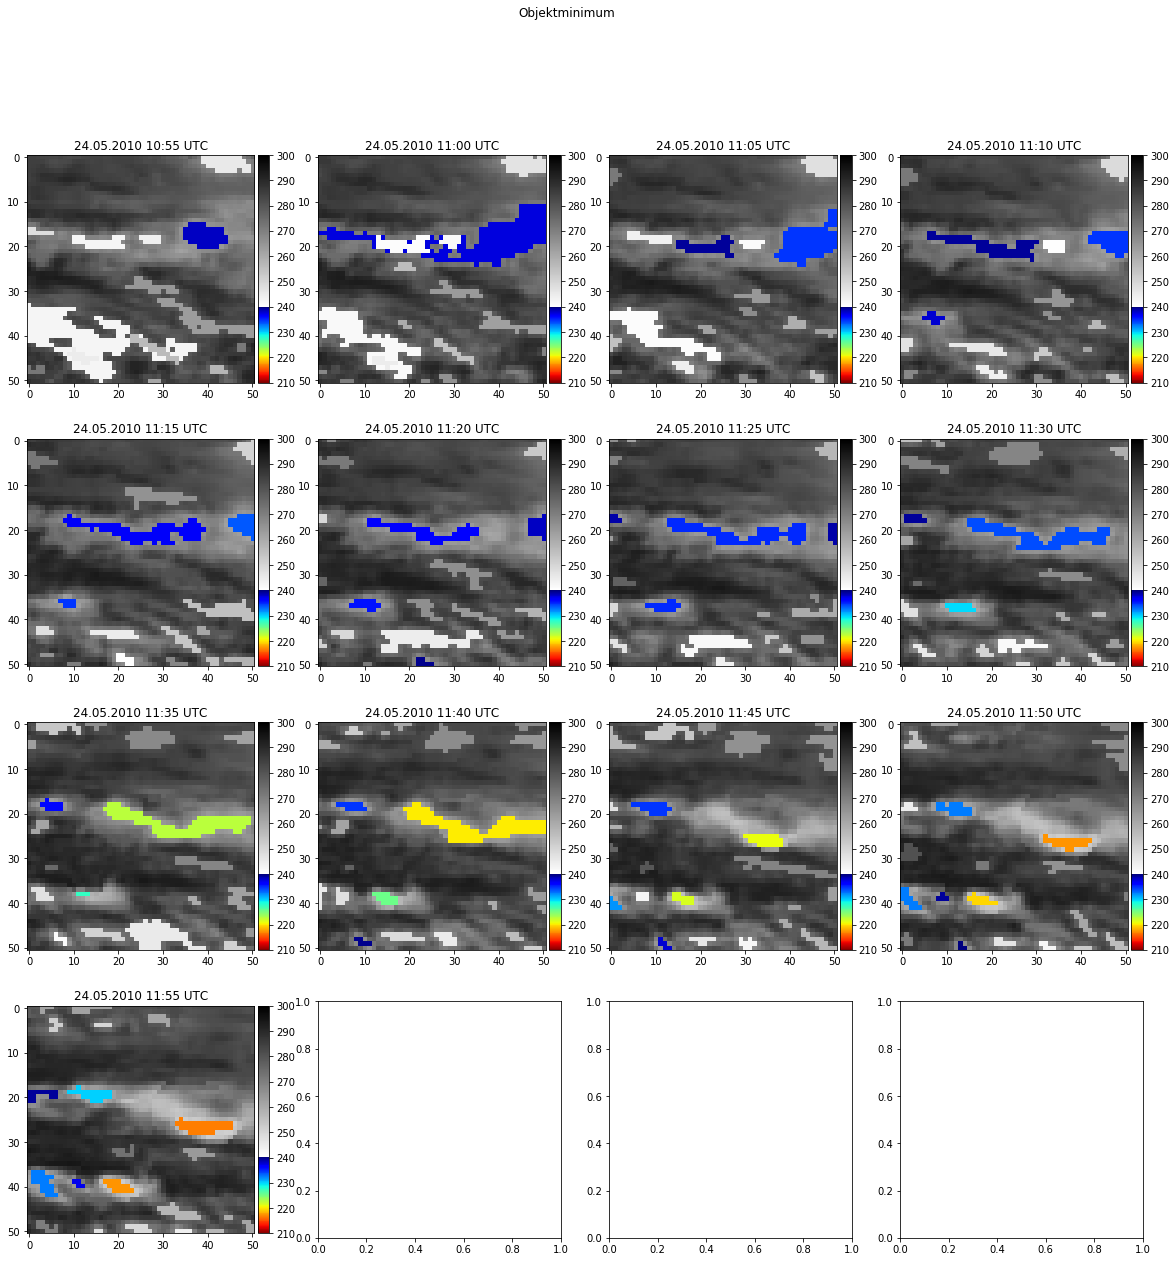

In [111]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
axs= ax.ravel()

for i, ir in enumerate(data['IR_108']):
    axs[i].imshow(ir,vmin=210,vmax=300,cmap='gray_r')
    p = axs[i].imshow(np.ma.masked_where(segmented[i]<1,object_minimum[i]),vmin=210,vmax=300,cmap=emap)    
    fc.colourbar(p)
    axs[i].set_title(u"{}".format(tlist[i].strftime("%d.%m.%Y %H:%M UTC")))
plt.suptitle("Objektminimum")

In [112]:
np.min(np.ma.masked_where(segmented[8]<1,object_minimum[8]))

222.8068530189691

In [113]:
np.unique(np.ma.masked_where(segmented[7]<1,object_minimum[7]))

masked_array(data=[230.0122801533999, 234.1077241177409,
                   239.42687185467085, 241.81553899147934,
                   245.69344717773077, 247.66275273378162,
                   249.36907349881497, 250.20750286841337,
                   250.62316790781827, 252.66740989113197,
                   254.85407689894276, 256.98056781008444,
                   259.23686756015485, 260.3417021854889,
                   261.2510922295802, 262.6855597138227,
                   263.7454310456369, 267.52232818164225,
                   269.021233595758, 269.35089536465273,
                   274.7785044456643, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False,  True],
       fill_value=1e+20)

Text(0.5, 0.98, 'Objektschwellwert')

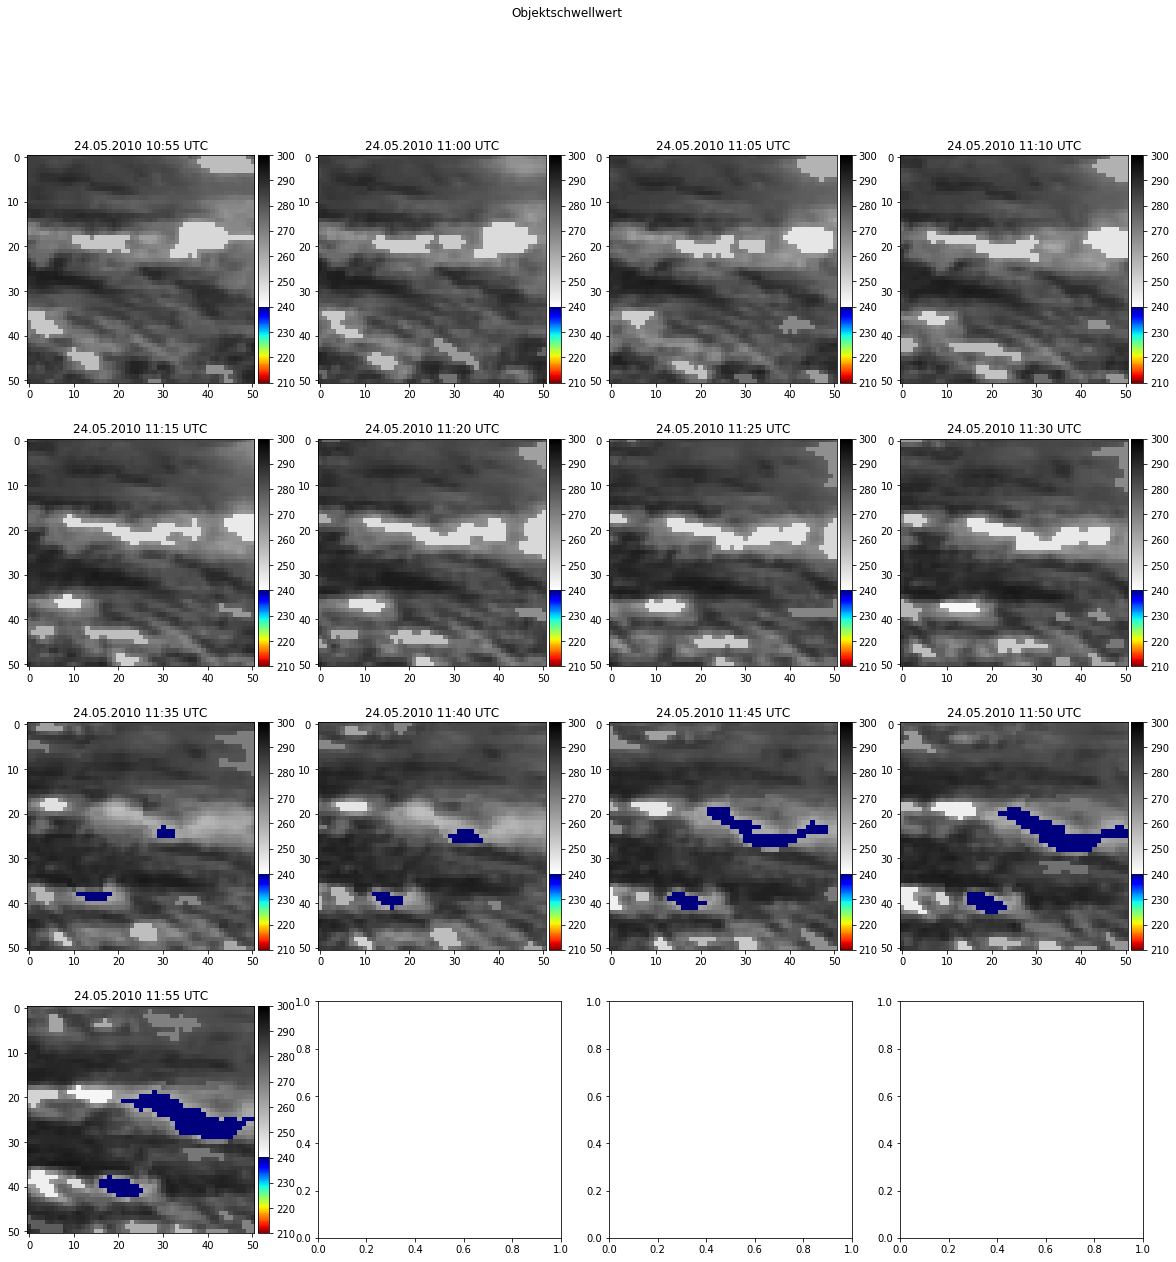

In [284]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
axs= ax.ravel()

for i, o in enumerate(objects):
    axs[i].imshow(data['IR_108'][i],vmin=210,vmax=300,cmap='gray_r')
    p = axs[i].imshow(np.ma.masked_where(segmented[i]<1,object_threshold[i]),vmin=210,vmax=300,cmap=emap)    
    fc.colourbar(p)
    axs[i].set_title(u"{}".format(tlist[i].strftime("%d.%m.%Y %H:%M UTC")))
plt.suptitle("Objektschwellwert")

In [305]:
threshs = np.arange(240,220,-10)
spreads = [5,7]
factors = np.arange(10,21,1)
T = np.arange(290,179,-1)

In [329]:
threshold = {t:{s:[] for s in spreads} for t in threshs}

In [325]:
for t in threshs:
    for s in spreads:
        #for f in factors:
            threshold[t][s] = [local_threshold(tm,273.15, t, 220,s,15) for tm in T]

In [326]:
line_colour = {5:'#ff0000aa',
               7:'#0000ffaa'}
lstyle = {240:':',
          230:'--'}

In [327]:
thresh_label = ["{} K".format(t) for t in threshs]
spread_label = ["{} K".format(s) for s in [5,7]]

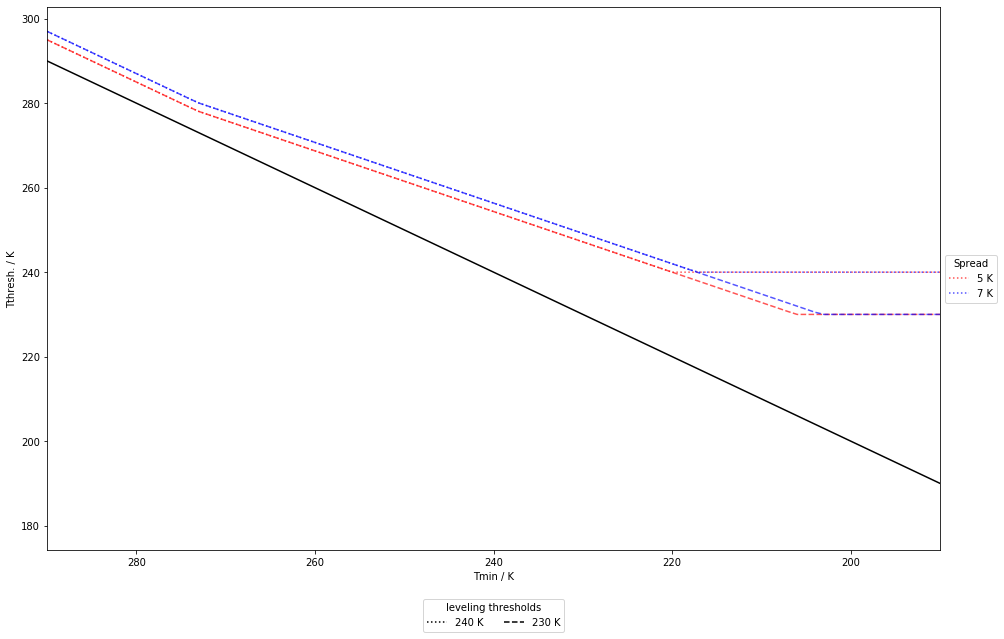

In [328]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
for t in threshs:
    for s in spreads:
        ax.plot(T,threshold[t][s],c=line_colour[s],linestyle=lstyle[t])
ax.plot(T,T,c='k')
ax.set_xlim(290,190)
ax.set_xlabel("Tmin / K")
ax.set_ylabel("Tthresh. / K")

# create legends
dummy_lines = []
for t_idx, t in enumerate(threshold):
    dummy_lines.append(ax.plot([],[], c="black", ls = lstyle[t])[0])
lines = ax.get_lines()

legend1 = plt.legend([lines[i] for i,s in enumerate(spreads)], 
                     spread_label, 
                     loc="center left",
                     title="Spread",
                     bbox_to_anchor=(1, 0.5))

legend2 = plt.legend([dummy_lines[i] for i,t in enumerate(threshold)],
                     thresh_label,
                     loc="upper center",
                     title="leveling thresholds",
                     bbox_to_anchor=(0.5, -0.08),
                     ncol=2)
ax.add_artist(legend1)

$$T_\mathrm{Schwellwert} = \mathrm{max}\left(T + 5\,\mathrm{K}; T\,\cdot\,5\,\mathrm{K} + 15 \frac{T - 273,15\,\mathrm{K}}{220,\mathrm{K} - 273,15\,\mathrm{K}}; 240\,\mathrm{K}\right)$$
